In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

In [5]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models

import numpy as np
import random

# from src.models.resnet import ResNet50
from src.norm.norm_layer import replace_norm_layer
from src.data.loaders import get_cifar_loader
from src.models.vgg import VGG16

from torchsummary import summary
from tqdm import tqdm

from IPython import display

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [8]:
def get_accuracy(model, dataloader, device='gpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [9]:
def get_loss(model, dataloader, criterion, device='gpu'):
    loss_ = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            loss = criterion(prediction, y)
            loss_ += loss.item()
    return loss / len(dataloader)

In [10]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:
            
            #print(data)
            
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            #loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[4].weight.grad.clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads

In [11]:
batch_size = 128
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
training_results_vgg16 = {}

# GN New

In [13]:
vgg16_gn_new = VGG16(norm='gn_plus_sequential_gn_first').to(device)

In [14]:
print(vgg16_gn_new)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GNPlusSequentialGNFirst()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GNPlusSequentialGNFirst()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GNPlusSequentialGNFirst()
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GNPlusSequentialGNFirst()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GNPlusSequentialGNFirst()
    (2): ReLU

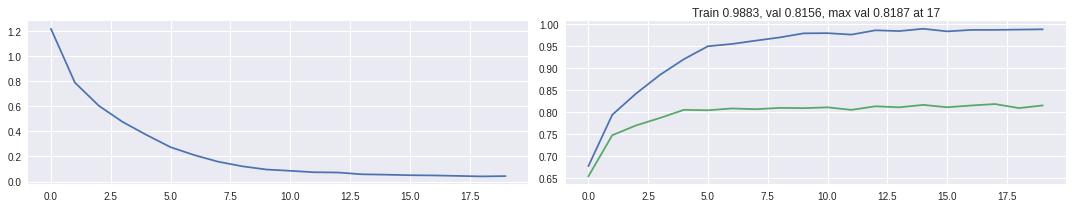

100%|██████████| 20/20 [19:24<00:00, 58.23s/epoch]


In [15]:
lr = 5e-4
model_name = '10_vgg16_gn_new'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn_plus_sequential_gn_first').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

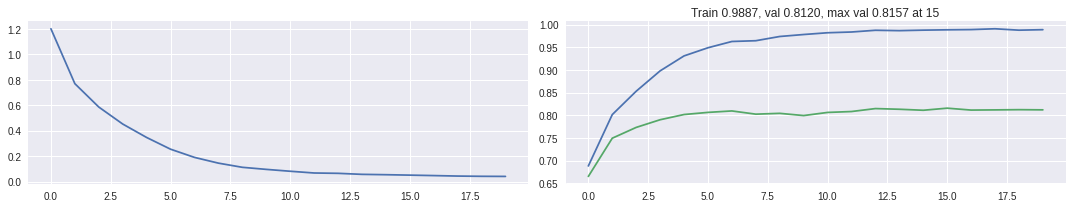

100%|██████████| 20/20 [35:36<00:00, 106.82s/epoch]


In [16]:
lr = 4e-4
model_name = '10_vgg16_gn_new'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn_plus_sequential_gn_first').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

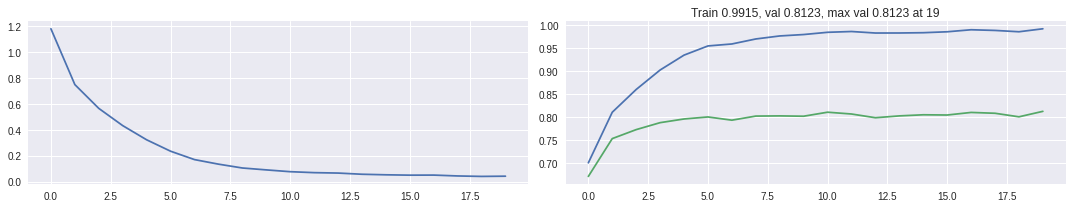

100%|██████████| 20/20 [36:34<00:00, 109.72s/epoch]


In [17]:
lr = 3e-4
model_name = '10_vgg16_gn_new'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn_plus_sequential_gn_first').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

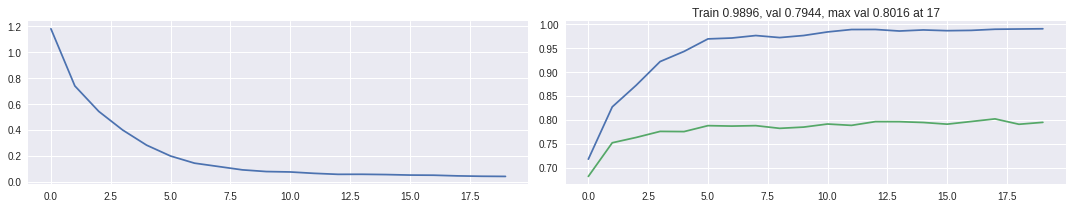

100%|██████████| 20/20 [36:33<00:00, 109.68s/epoch]


In [18]:
lr = 2e-4
model_name = '10_vgg16_gn_new'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn_plus_sequential_gn_first').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

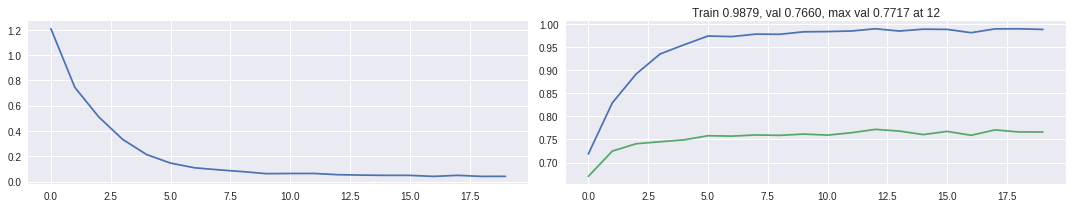

100%|██████████| 20/20 [35:50<00:00, 107.54s/epoch]


In [19]:
lr = 1e-4
model_name = '10_vgg16_gn_new'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn_plus_sequential_gn_first').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

In [20]:
training_results_vgg16.keys()

dict_keys(['10_vgg16_gn_new_lr_0.0005', '10_vgg16_gn_new_lr_0.0004', '10_vgg16_gn_new_lr_0.0003', '10_vgg16_gn_new_lr_0.0002', '10_vgg16_gn_new_lr_0.0001'])

In [21]:
grads_1 = np.array(training_results_vgg16['10_vgg16_gn_new_lr_0.0001']).flatten()
grads_2 = np.array(training_results_vgg16['10_vgg16_gn_new_lr_0.0002']).flatten()
grads_3 = np.array(training_results_vgg16['10_vgg16_gn_new_lr_0.0003']).flatten()
grads_4 = np.array(training_results_vgg16['10_vgg16_gn_new_lr_0.0004']).flatten()
grads_5 = np.array(training_results_vgg16['10_vgg16_gn_new_lr_0.0005']).flatten()

In [22]:
flattened_grads_1 = np.array(grads_1).flatten()
flattened_grads_2 = np.array(grads_2).flatten()
flattened_grads_3 = np.array(grads_3).flatten()
flattened_grads_4 = np.array(grads_4).flatten()
flattened_grads_5 = np.array(grads_5).flatten()

diff_grads_1 = []
diff_grads_2 = []
diff_grads_3 = []
diff_grads_4 = []
diff_grads_5 = []
for i in range(1, len(flattened_grads_1)):
  diff_grads_1.append((flattened_grads_1[i-1] - flattened_grads_1[i]).norm(p=2).item())
  diff_grads_2.append((flattened_grads_2[i-1] - flattened_grads_2[i]).norm(p=2).item())
  diff_grads_3.append((flattened_grads_3[i-1] - flattened_grads_3[i]).norm(p=2).item())
  diff_grads_4.append((flattened_grads_4[i-1] - flattened_grads_4[i]).norm(p=2).item())
  diff_grads_5.append((flattened_grads_5[i-1] - flattened_grads_5[i]).norm(p=2).item())
  
min_curve_gn_new = []
max_curve_gn_new = []
for i in range(len(diff_grads_1)):
    min_curve_gn_new.append(np.min([diff_grads_1[i], diff_grads_2[i], diff_grads_3[i], diff_grads_4[i], diff_grads_5[i]]))
    max_curve_gn_new.append(np.max([diff_grads_1[i], diff_grads_2[i], diff_grads_3[i], diff_grads_4[i], diff_grads_5[i]]))

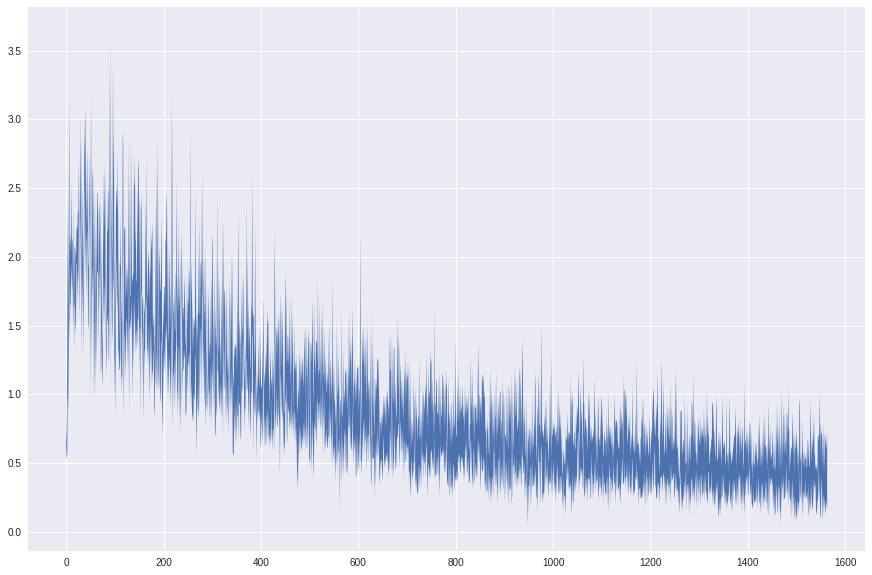

In [23]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve_gn_new)//5+1), min_curve_gn_new[::5], max_curve_gn_new[::5])

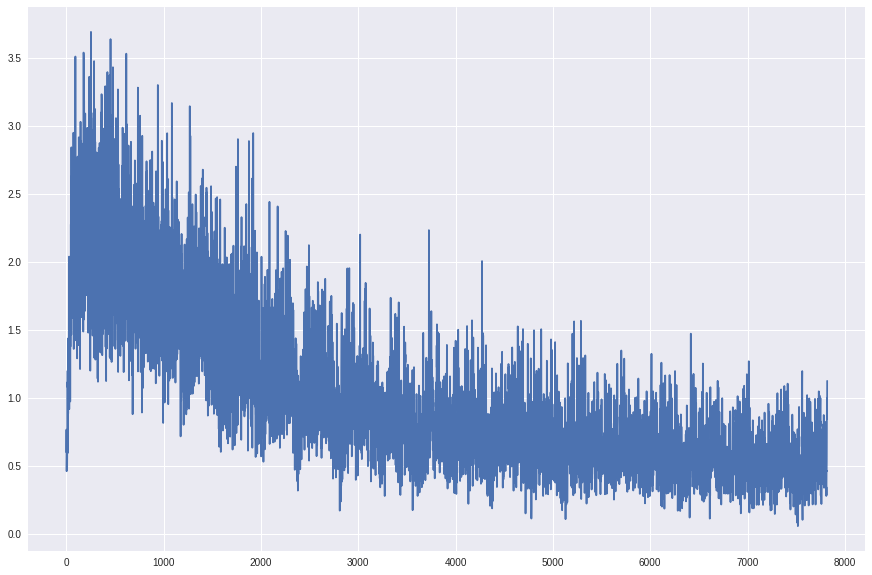

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(range(len(diff_grads_1)), diff_grads_1)

# GN

In [25]:
vgg16_gn = VGG16(norm='gn').to(device)

In [26]:
print(vgg16_gn)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm2d()
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm2d()
    (2): ReLU()
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

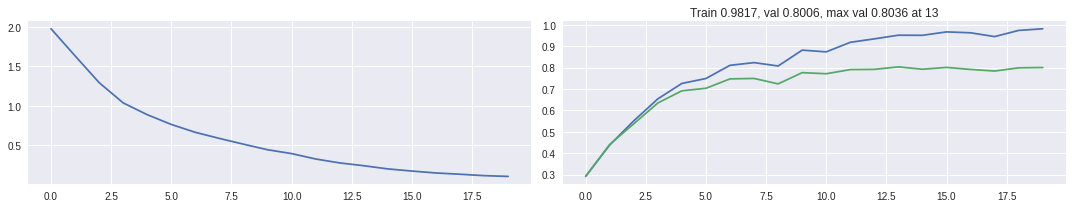

100%|██████████| 20/20 [22:22<00:00, 67.15s/epoch]


In [27]:
lr = 5e-4
model_name = '10_vgg16_gn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

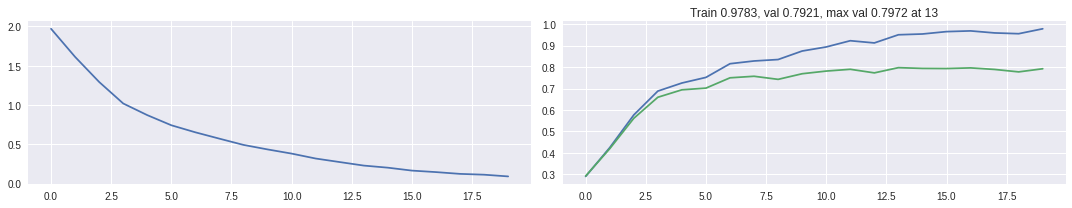

100%|██████████| 20/20 [23:31<00:00, 70.58s/epoch]


In [28]:
lr = 4e-4
model_name = '10_vgg16_gn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

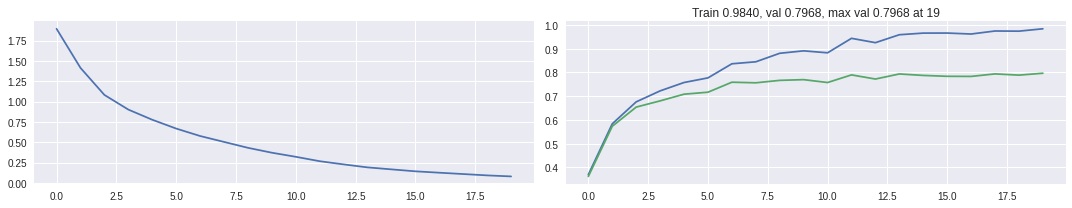

100%|██████████| 20/20 [20:46<00:00, 62.33s/epoch]


In [29]:
lr = 3e-4
model_name = '10_vgg16_gn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

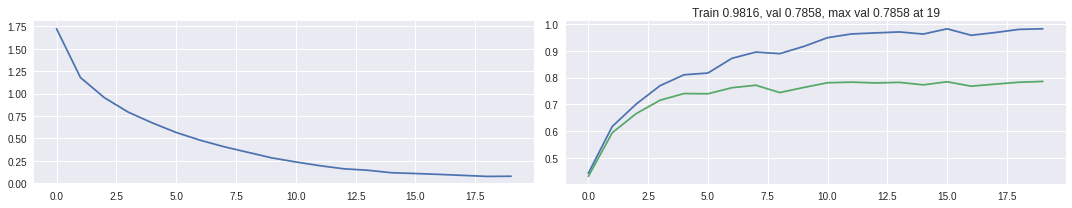

100%|██████████| 20/20 [19:03<00:00, 57.17s/epoch]


In [30]:
lr = 2e-4
model_name = '10_vgg16_gn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

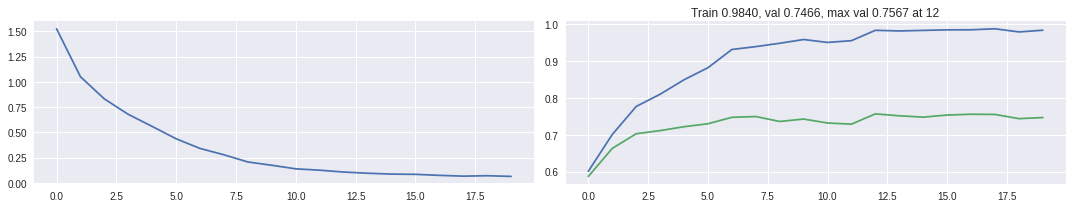

100%|██████████| 20/20 [18:59<00:00, 57.00s/epoch]


In [31]:
lr = 1e-4
model_name = '10_vgg16_gn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='gn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

In [32]:
grads_1_gn = np.array(training_results_vgg16['10_vgg16_gn_lr_0.0001']).flatten()
grads_2_gn = np.array(training_results_vgg16['10_vgg16_gn_lr_0.0002']).flatten()
grads_3_gn = np.array(training_results_vgg16['10_vgg16_gn_lr_0.0003']).flatten()
grads_4_gn = np.array(training_results_vgg16['10_vgg16_gn_lr_0.0004']).flatten()
grads_5_gn = np.array(training_results_vgg16['10_vgg16_gn_lr_0.0005']).flatten()

In [33]:
flattened_grads_1_gn = np.array(grads_1_gn).flatten()
flattened_grads_2_gn = np.array(grads_2_gn).flatten()
flattened_grads_3_gn = np.array(grads_3_gn).flatten()
flattened_grads_4_gn = np.array(grads_4_gn).flatten()
flattened_grads_5_gn = np.array(grads_5_gn).flatten()

diff_grads_1_gn = []
diff_grads_2_gn = []
diff_grads_3_gn = []
diff_grads_4_gn = []
diff_grads_5_gn = []
for i in range(1, len(flattened_grads_1_gn)):
  diff_grads_1_gn.append((flattened_grads_1_gn[i-1] - flattened_grads_1_gn[i]).norm(p=2).item())
  diff_grads_2_gn.append((flattened_grads_2_gn[i-1] - flattened_grads_2_gn[i]).norm(p=2).item())
  diff_grads_3_gn.append((flattened_grads_3_gn[i-1] - flattened_grads_3_gn[i]).norm(p=2).item())
  diff_grads_4_gn.append((flattened_grads_4_gn[i-1] - flattened_grads_4_gn[i]).norm(p=2).item())
  diff_grads_5_gn.append((flattened_grads_5_gn[i-1] - flattened_grads_5_gn[i]).norm(p=2).item())
  
min_curve_gn = []
max_curve_gn = []
for i in range(len(diff_grads_1_gn)):
    min_curve_gn.append(np.min([diff_grads_1_gn[i], diff_grads_2_gn[i], diff_grads_3_gn[i], diff_grads_4_gn[i], diff_grads_5_gn[i]]))
    max_curve_gn.append(np.max([diff_grads_1_gn[i], diff_grads_2_gn[i], diff_grads_3_gn[i], diff_grads_4_gn[i], diff_grads_5_gn[i]]))

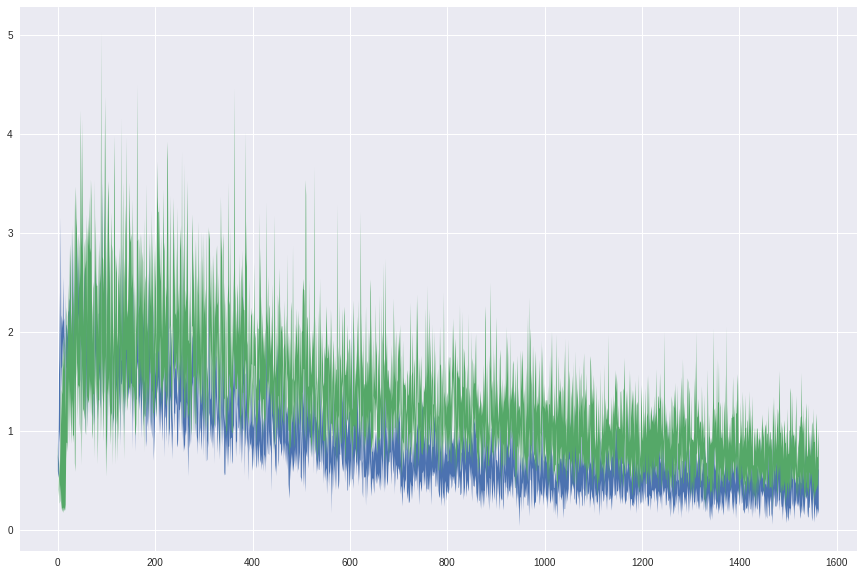

In [34]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve_gn_new)//5+1), min_curve_gn_new[::5], max_curve_gn_new[::5])
plt.fill_between(range(len(min_curve_gn)//5+1), min_curve_gn[::5], max_curve_gn[::5])
plt.show()

/home/kaist/anaconda3/envs/assn2/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


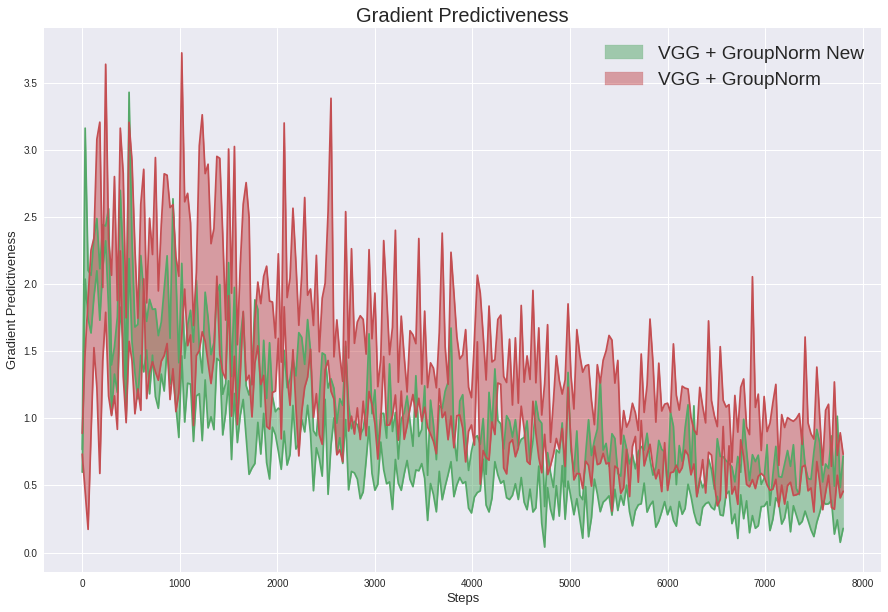

In [35]:
step = 30
steps = np.arange(0, len(min_curve_gn_new), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve_gn_new[::step], max_curve_gn_new[::step],
                alpha=0.5, color='C1', label='VGG + GroupNorm New')
plt.plot(steps, min_curve_gn_new[::step], color='C1')
plt.plot(steps, max_curve_gn_new[::step], color='C1')

plt.fill_between(steps, min_curve_gn[::step], max_curve_gn[::step],
                alpha=0.5, color='C2', label='VGG + GroupNorm')
plt.plot(steps, min_curve_gn[::step], color='C2')
plt.plot(steps, max_curve_gn[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'gradient_predictiveness_gn_new_vs_gn.png'), dpi=500, quality=100)
plt.show()

/home/kaist/anaconda3/envs/assn2/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


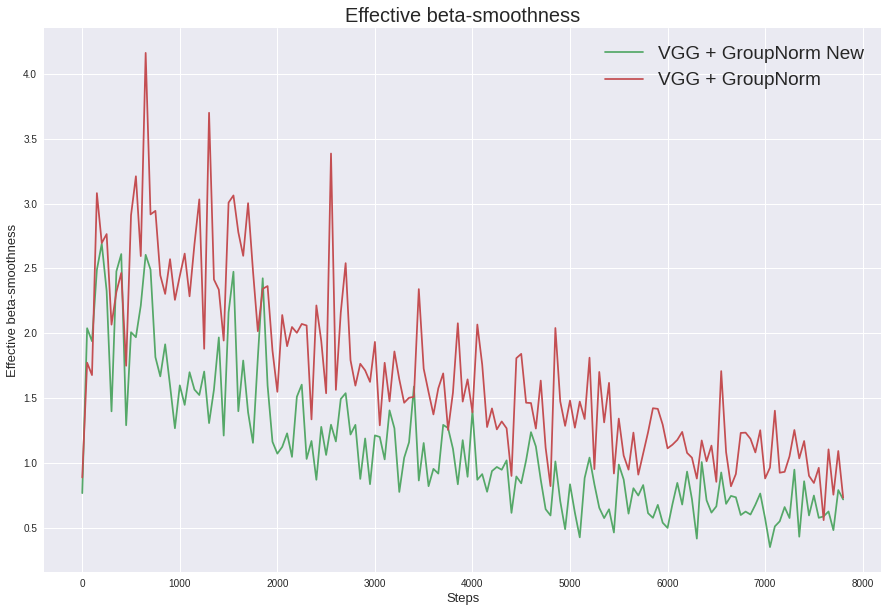

In [36]:
step = 50
steps = np.arange(0, len(min_curve_gn_new), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, max_curve_gn_new[::step], color='C1', label='VGG + GroupNorm New')

plt.plot(steps, max_curve_gn[::step], color='C2', label='VGG + GroupNorm')

plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'effective_beta_smoothness_gn_new_vs_gn.png'), dpi=500, quality=100)
plt.show()

# BN

In [37]:
vgg16_bn = VGG16(norm='bn').to(device)

In [38]:
print(vgg16_bn)

VGG16(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d

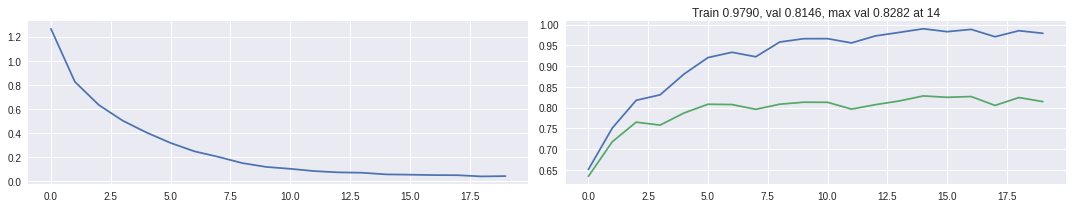

100%|██████████| 20/20 [14:48<00:00, 44.44s/epoch]


In [39]:
lr = 5e-4
model_name = '10_vgg16_bn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

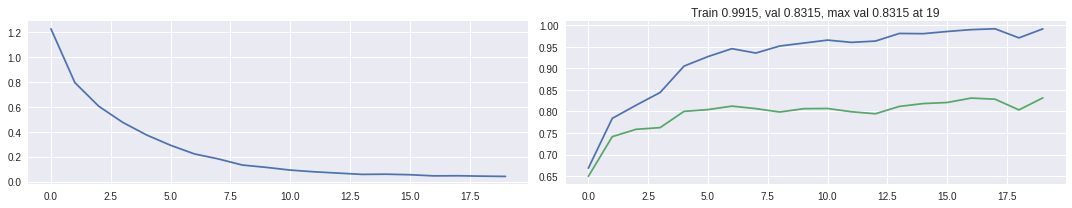

100%|██████████| 20/20 [12:30<00:00, 37.52s/epoch]


In [40]:
lr = 4e-4
model_name = '10_vgg16_bn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

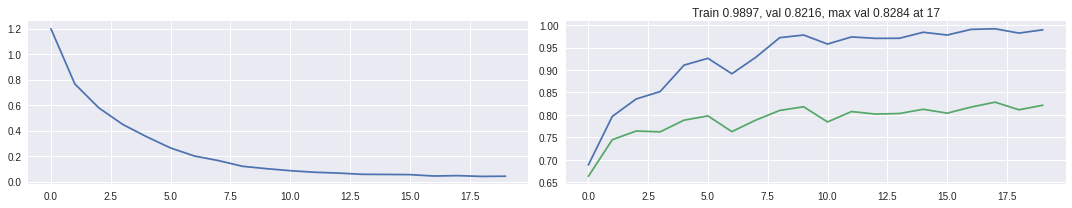

100%|██████████| 20/20 [05:41<00:00, 17.09s/epoch]


In [41]:
lr = 3e-4
model_name = '10_vgg16_bn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

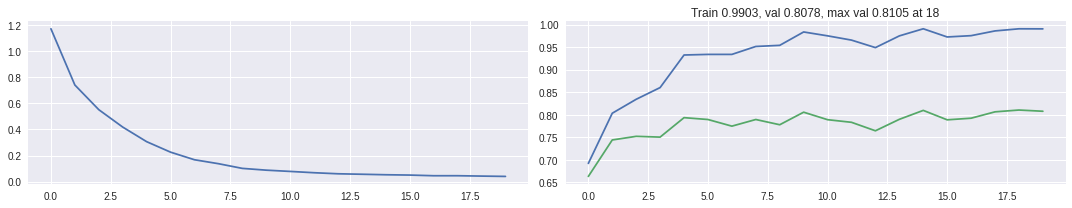

100%|██████████| 20/20 [05:25<00:00, 16.27s/epoch]


In [42]:
lr = 2e-4
model_name = '10_vgg16_bn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

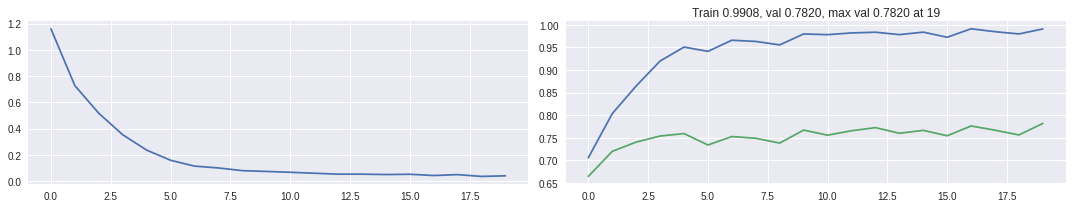

100%|██████████| 20/20 [05:18<00:00, 15.91s/epoch]


In [43]:
lr = 1e-4
model_name = '10_vgg16_bn'
experiment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experiment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = VGG16(norm='bn').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experiment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=20, 
                                           best_model_path=model_path)

In [44]:
grads_1 = np.array(training_results_vgg16['10_vgg16_bn_lr_0.0001']).flatten()
grads_2 = np.array(training_results_vgg16['10_vgg16_bn_lr_0.0002']).flatten()
grads_3 = np.array(training_results_vgg16['10_vgg16_bn_lr_0.0003']).flatten()
grads_4 = np.array(training_results_vgg16['10_vgg16_bn_lr_0.0004']).flatten()
grads_5 = np.array(training_results_vgg16['10_vgg16_bn_lr_0.0005']).flatten()

In [45]:
flattened_grads_1 = np.array(grads_1).flatten()
flattened_grads_2 = np.array(grads_2).flatten()
flattened_grads_3 = np.array(grads_3).flatten()
flattened_grads_4 = np.array(grads_4).flatten()
flattened_grads_5 = np.array(grads_5).flatten()

diff_grads_1 = []
diff_grads_2 = []
diff_grads_3 = []
diff_grads_4 = []
diff_grads_5 = []
for i in range(1, len(flattened_grads_1)):
  diff_grads_1.append((flattened_grads_1[i-1] - flattened_grads_1[i]).norm(p=2).item())
  diff_grads_2.append((flattened_grads_2[i-1] - flattened_grads_2[i]).norm(p=2).item())
  diff_grads_3.append((flattened_grads_3[i-1] - flattened_grads_3[i]).norm(p=2).item())
  diff_grads_4.append((flattened_grads_4[i-1] - flattened_grads_4[i]).norm(p=2).item())
  diff_grads_5.append((flattened_grads_5[i-1] - flattened_grads_5[i]).norm(p=2).item())
  
min_curve_bn = []
max_curve_bn = []
for i in range(len(diff_grads_1)):
    min_curve_bn.append(np.min([diff_grads_1[i], diff_grads_2[i], diff_grads_3[i], diff_grads_4[i], diff_grads_5[i]]))
    max_curve_bn.append(np.max([diff_grads_1[i], diff_grads_2[i], diff_grads_3[i], diff_grads_4[i], diff_grads_5[i]]))

/home/kaist/anaconda3/envs/assn2/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


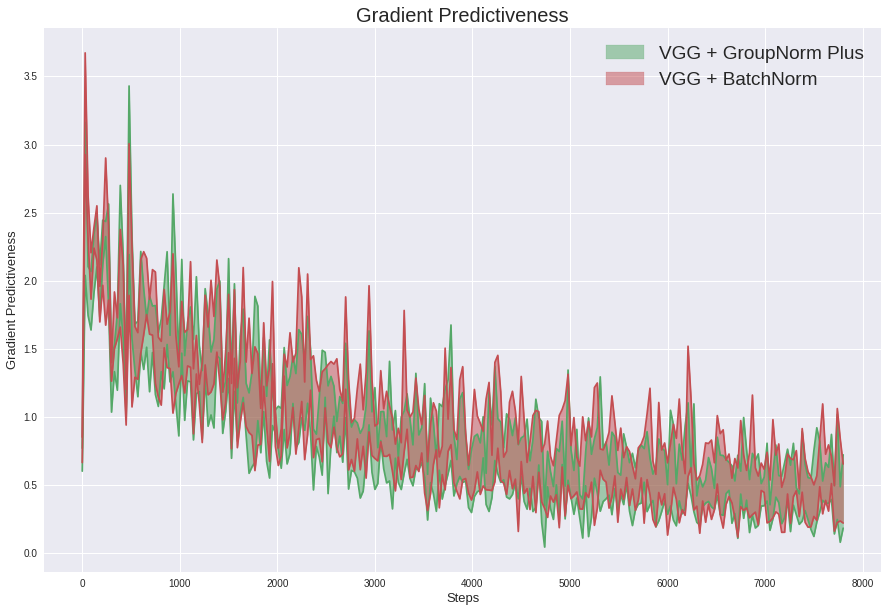

In [48]:
step = 30
steps = np.arange(0, len(min_curve_gn_new), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve_gn_new[::step], max_curve_gn_new[::step],
                alpha=0.5, color='C1', label='VGG + GroupNorm Plus')
plt.plot(steps, min_curve_gn_new[::step], color='C1')
plt.plot(steps, max_curve_gn_new[::step], color='C1')

plt.fill_between(steps, min_curve_bn[::step], max_curve_bn[::step],
                alpha=0.5, color='C2', label='VGG + BatchNorm')
plt.plot(steps, min_curve_bn[::step], color='C2')
plt.plot(steps, max_curve_bn[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'gradient_predictiveness_gn_new_vs_bn.png'), dpi=500, quality=100)
plt.show()

/home/kaist/anaconda3/envs/assn2/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


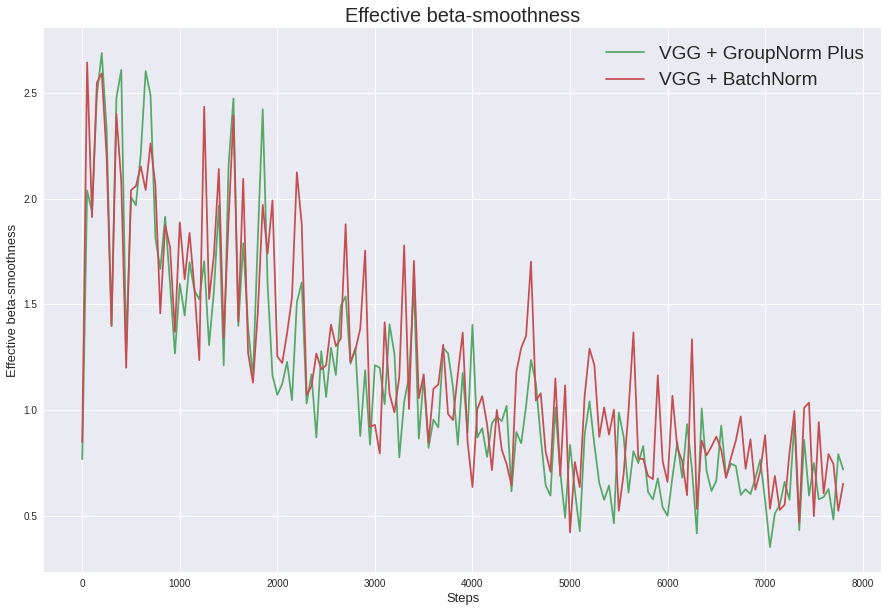

In [49]:
step = 50
steps = np.arange(0, len(min_curve_gn_new), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, max_curve_gn_new[::step], color='C1', label='VGG + GroupNorm Plus')

plt.plot(steps, max_curve_bn[::step], color='C2', label='VGG + BatchNorm')

plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'effective_beta_smoothness_gn_new_vs_bn.png'), dpi=500, quality=100)
plt.show()

In [50]:
import pickle
def save_obj(obj, name ):
    with open('../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [51]:
save_obj(training_results_vgg16, '10_grad_pred_result')

In [53]:
test = load_obj('10_grad_pred_result')